<a href="https://colab.research.google.com/github/ulung3ko/deep-learning-assignment-hyperparameter-tuning/blob/main/hyperparameter_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install dan Import beberapa library yang dibutuhkan pada tugas ini

In [1]:
!pip install yfinance
!pip install yahoofinancials
!pip install scikeras
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for yahoofinancials: filename=yahoofinancials-1.20-py3-none-any.whl size=38618 sha256=43c184167715a1f77c5afbf62c01bdf9cf43ee5318549f1aeddfa046628fecfa
  Stored in directory: /root/.cache/pip/wheels/c6/bc/18/da12b3c280d31beeac0c0f491c8f370da7c1473a56d7d4b5f3
Successfully built yahoofinancials
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 11.3 MB/s eta 0:00:00


In [2]:
# Import Library
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import yfinance as yf
from yahoofinancials import YahooFinancials
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam, RMSprop

# Unduh dataset yang sesuai daengan UTS sebelumnya, yaitu data saham Samsung

In [3]:
samsung_df = yf.download('005930.KS',
                      start='2018-12-31',
                      end='2025-05-29',
                      progress=False,
)
print(samsung_df.head())

/tmp/ipython-input-3-1569164090.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  samsung_df = yf.download('005930.KS',


Price              Close          High           Low          Open    Volume
Ticker         005930.KS     005930.KS     005930.KS     005930.KS 005930.KS
Date                                                                        
2019-01-02  32866.585938  33417.896411  32696.951946  33417.896411   7847664
2019-01-03  31891.179688  32696.940876  31763.954237  32484.898458  12471493
2019-01-04  31763.958984  31891.184454  31255.057105  31763.958984  14108958
2019-01-07  32866.585938  32993.811431  32060.824476  32230.458468  12748997
2019-01-08  32315.275391  33248.262344  32188.049897  32230.458395  12756554


# Perbaiki nama kolom pada dataset yang baru saja di download

In [4]:
samsung_df.info()
samsung_df.columns = samsung_df.columns.get_level_values(0)
print(samsung_df.columns.tolist())
print(samsung_df.head())
print(f"Tipe Index Tanggal: {type(samsung_df.index)}, Nama Index: {samsung_df.index.name}, Tipe Data Index: {samsung_df.index.dtype}")

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1572 entries, 2019-01-02 to 2025-05-28
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   (Close, 005930.KS)   1572 non-null   float64
 1   (High, 005930.KS)    1572 non-null   float64
 2   (Low, 005930.KS)     1572 non-null   float64
 3   (Open, 005930.KS)    1572 non-null   float64
 4   (Volume, 005930.KS)  1572 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 73.7 KB
['Close', 'High', 'Low', 'Open', 'Volume']
Price              Close          High           Low          Open    Volume
Date                                                                        
2019-01-02  32866.585938  33417.896411  32696.951946  33417.896411   7847664
2019-01-03  31891.179688  32696.940876  31763.954237  32484.898458  12471493
2019-01-04  31763.958984  31891.184454  31255.057105  31763.958984  14108958
2019-01-07  32866.585938  32993.811431  32060.8

# Pilih variabel X dan y untuk modelling (fitur dan target)

In [5]:
feature_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
target_column = 'Close'

data_to_process = samsung_df[feature_columns].copy()
print(f"Fitur yang digunakan: {feature_columns}")
print(f"Target prediksi: {target_column}")
print("Shape data_to_process:", data_to_process.shape)

Fitur yang digunakan: ['Open', 'High', 'Low', 'Close', 'Volume']
Target prediksi: Close
Shape data_to_process: (1572, 5)


# Pembagian data train, test dan val

In [6]:
total_data_len = len(data_to_process)
train_split_ratio = 0.7
val_split_ratio = 0.15

train_len = int(total_data_len * train_split_ratio)
val_len = int(total_data_len * val_split_ratio)

train_data = data_to_process.iloc[:train_len]
val_data = data_to_process.iloc[train_len : train_len + val_len]
test_data = data_to_process.iloc[train_len + val_len :]

print(f"Data keseluruhan: {total_data_len}")
print(f"Data pelatihan: {len(train_data)}")
print(f"Data validasi: {len(val_data)}")
print(f"Data pengujian: {len(test_data)}")

Data keseluruhan: 1572
Data pelatihan: 1100
Data validasi: 235
Data pengujian: 237


# Normalisasi data

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train_data)

train_scaled = scaler.transform(train_data)
val_scaled = scaler.transform(val_data)
test_scaled = scaler.transform(test_data)

target_col_index = feature_columns.index(target_column)

# Pembuatan sequence pada data

In [8]:
def create_sequences(data_scaled, time_steps_param, target_col_idx_param):
    X_list, y_list = [], []
    for i in range(time_steps_param, len(data_scaled)):
        X_list.append(data_scaled[i - time_steps_param:i, :])
        y_list.append(data_scaled[i, target_col_idx_param])
    return np.array(X_list), np.array(y_list)

TIME_STEPS = 60

X_train, y_train = create_sequences(train_scaled, TIME_STEPS, target_col_index)
X_val, y_val = create_sequences(val_scaled, TIME_STEPS, target_col_index)
X_test, y_test = create_sequences(test_scaled, TIME_STEPS, target_col_index)

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

time_steps_model = X_train.shape[1]
num_features_model = X_train.shape[2]
print(f"Time steps untuk model: {time_steps_model}, Jumlah Fitur: {num_features_model}")

model_results = {}

X_train: (1040, 60, 5), y_train: (1040,)
X_val: (175, 60, 5), y_val: (175,)
X_test: (177, 60, 5), y_test: (177,)
Time steps untuk model: 60, Jumlah Fitur: 5


# Mendefinisikan model untuk di tuning nantinya

In [9]:
# LSTM untuk di Tuning
def build_lstm_model(units=50, dropout_rate=0.2, dense_units=25, activation='relu', optimizer='adam'):
    model = Sequential(name="LSTM_Model")
    model.add(LSTM(units=units, return_sequences=True, input_shape=(time_steps_model, num_features_model)))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=dense_units, activation=activation))
    model.add(Dense(units=1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [10]:
# GRU untuk di Tuning
def build_gru_model(units=50, dropout_rate=0.2, dense_units=25, activation='relu', optimizer='adam'):
    model = Sequential(name="GRU_Model")
    model.add(GRU(units=units, return_sequences=True, input_shape=(time_steps_model, num_features_model)))
    model.add(Dropout(dropout_rate))
    model.add(GRU(units=units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=dense_units, activation=activation))
    model.add(Dense(units=1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Menjalankan Random Search CV dengan Keras Tuner

## LSTM

In [11]:
# Definisikan fungsi build model untuk Keras Tuner
def build_lstm_model(hp):
    model = Sequential(name="LSTM_Model")

    # LSTM Layer
    model.add(LSTM(
        units=hp.Int('units', min_value=32, max_value=256, step=32),
        activation=hp.Choice('activation', ['relu', 'tanh']),
        return_sequences=False,
        input_shape=(X_train.shape[1], X_train.shape[2])
    ))

    # Dropout
    model.add(Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))

    # Dense output
    model.add(Dense(1))

    # Compile
    optimizer_choice = hp.Choice('optimizer', ['adam', 'rmsprop'])
    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=hp.Choice('learning_rate', [0.1, 0.001, 0.0001]))
    else:
        optimizer = RMSprop(learning_rate=hp.Choice('learning_rate', [0.1, 0.001, 0.0001]))

    model.compile(optimizer=optimizer, loss='mse')

    return model

# Inisiasi Tuner
tuner = kt.RandomSearch(
    build_lstm_model,
    objective='val_loss',
    max_trials=10,  # Jumlah total konfigurasi yang dicoba
    executions_per_trial=1,  # Ulangi training berapa kali per kombinasi
    directory='keras_tuner_dir',
    project_name='lstm_tuning'
)

# Definisikan Early Stopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=5,
                           restore_best_weights=True)

# Mulai tuning
tuner.search(X_train, y_train,
             epochs=20,
             validation_data=(X_val, y_val),
             callbacks=[early_stop])

# Simpan model terbaik ke variabel
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparams = tuner.get_best_hyperparameters(num_trials=1)[0]

print("\nBest Hyperparameters:")
for param in best_hyperparams.values:
    print(f"{param}: {best_hyperparams.get(param)}")

Trial 10 Complete [00h 00m 16s]
val_loss: 0.0013474964071065187

Best val_loss So Far: 0.0007710842764936388
Total elapsed time: 00h 01m 33s

Best Hyperparameters:
units: 256
activation: tanh
dropout: 0.1
optimizer: rmsprop
learning_rate: 0.001


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 7 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## GRU

In [12]:
# Definisikan fungsi build model GRU
def build_gru_model(hp):
    model = Sequential(name="GRU_Model")

    # GRU Layer
    model.add(GRU(
        units=hp.Int('units', min_value=32, max_value=256, step=32),
        activation=hp.Choice('activation', ['relu', 'tanh']),
        return_sequences=False,
        input_shape=(X_train.shape[1], X_train.shape[2])
    ))

    # Dropout
    model.add(Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))

    # Dense output
    model.add(Dense(1))

    # Compile
    optimizer_choice = hp.Choice('optimizer', ['adam', 'rmsprop'])
    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=hp.Choice('learning_rate', [0.1, 0.001, 0.0001]))
    else:
        optimizer = RMSprop(learning_rate=hp.Choice('learning_rate', [0.1, 0.001, 0.0001]))

    model.compile(optimizer=optimizer, loss='mse')

    return model

# Inisisasi Tuner
tuner_gru = kt.RandomSearch(
    build_gru_model,
    objective='val_loss',
    max_trials=10,  # Jumlah total konfigurasi yang dicoba
    executions_per_trial=1,  # Ulangi training berapa kali per kombinasi
    directory='keras_tuner_dir',
    project_name='gru_tuning'
)

# Tuning GRU
tuner_gru.search(X_train, y_train,
                 epochs=20,
                 validation_data=(X_val, y_val),
                 callbacks=[early_stop])

# Simpan model terbaik ke variabel
best_gru_model = tuner_gru.get_best_models(num_models=1)[0]
best_gru_hyperparams = tuner_gru.get_best_hyperparameters(num_trials=1)[0]

print("\nBest GRU Hyperparameters:")
for param in best_gru_hyperparams.values:
    print(f"{param}: {best_gru_hyperparams.get(param)}")

Trial 10 Complete [00h 00m 08s]
val_loss: 0.0039041638374328613

Best val_loss So Far: 0.0005540791316889226
Total elapsed time: 00h 01m 30s

Best GRU Hyperparameters:
units: 32
activation: tanh
dropout: 0.0
optimizer: adam
learning_rate: 0.001


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## Hasil Tuning

In [13]:
print("Hasil Hyperparameter Tuning")
print("\nLSTM Model - Best Hyperparameters:")
print(f"Units: {best_hyperparams.get('units')}")
print(f"Dropout: {best_hyperparams.get('dropout')}")
print(f"Learning Rate: {best_hyperparams.get('learning_rate')}")

print("\nGRU Model - Best Hyperparameters:")
print(f"Units: {best_gru_hyperparams.get('units')}")
print(f"Dropout: {best_gru_hyperparams.get('dropout')}")
print(f"Learning Rate: {best_gru_hyperparams.get('learning_rate')}")

Hasil Hyperparameter Tuning

LSTM Model - Best Hyperparameters:
Units: 256
Dropout: 0.1
Learning Rate: 0.001

GRU Model - Best Hyperparameters:
Units: 32
Dropout: 0.0
Learning Rate: 0.001


## Training Model Terbaik

In [14]:
# Training model LSTM terbaik
history_lstm = best_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=25,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
    verbose=1
)

# Training model GRU terbaik
history_gru = best_gru_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=25,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
    verbose=1
)

Epoch 1/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 2/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 3/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0013 - val_loss: 8.1896e-04
Epoch 4/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 5/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 6/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.1867e-04 - val_loss: 0.0042
Epoch 7/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 8/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.0409e-04 - val_loss: 0.0017
Epoch 9/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.1367e-04 - val_loss: 7.0057e-04
Epoch 10/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.0925e-04 - val_loss: 0.0014
Epoch 11/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.9902e-04 - val_loss: 0.0012
Epoch 12/25
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10m

# Evaluasi model

In [15]:
predictions_scaled_lstm = best_model.predict(X_test)

y_test_inverse_dummy = np.zeros((len(y_test), num_features_model))
y_test_inverse_dummy[:, target_col_index] = y_test.ravel()
y_test_actual = scaler.inverse_transform(y_test_inverse_dummy)[:, target_col_index]

predictions_inverse_dummy_lstm = np.zeros((len(predictions_scaled_lstm), num_features_model))
predictions_inverse_dummy_lstm[:, target_col_index] = predictions_scaled_lstm.ravel()
predictions_lstm = scaler.inverse_transform(predictions_inverse_dummy_lstm)[:, target_col_index]

rmse_lstm = np.sqrt(mean_squared_error(y_test_actual, predictions_lstm))
mae_lstm = mean_absolute_error(y_test_actual, predictions_lstm)

model_results['LSTM'] = {
    'RMSE': rmse_lstm,
    'MAE': mae_lstm,
    'Predictions': predictions_lstm,
    'History': history_lstm
}

print(f"Hasil Evaluasi LSTM:")
print(f"RMSE: {rmse_lstm:.2f}")
print(f"MAE: {mae_lstm:.2f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Hasil Evaluasi LSTM:
RMSE: 1408.00
MAE: 1081.89


In [16]:
predictions_scaled_gru = best_gru_model.predict(X_test)

predictions_inverse_dummy_gru = np.zeros((len(predictions_scaled_gru), num_features_model))
predictions_inverse_dummy_gru[:, target_col_index] = predictions_scaled_gru.ravel()
predictions_gru = scaler.inverse_transform(predictions_inverse_dummy_gru)[:, target_col_index]

rmse_gru = np.sqrt(mean_squared_error(y_test_actual, predictions_gru))
mae_gru = mean_absolute_error(y_test_actual, predictions_gru)

model_results['GRU'] = {
    'RMSE': rmse_gru,
    'MAE': mae_gru,
    'Predictions': predictions_gru,
    'History': history_gru
}

print(f"Hasil Evaluasi GRU:")
print(f"RMSE: {rmse_gru:.2f}")
print(f"MAE: {mae_gru:.2f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Hasil Evaluasi GRU:
RMSE: 1241.18
MAE: 927.58


In [17]:
results_summary = []
for name, metrics_dict in model_results.items():
    results_summary.append({
        'Model': name,
        'RMSE': metrics_dict['RMSE'],
        'MAE': metrics_dict['MAE'],
    })
results_df = pd.DataFrame(results_summary)

print(results_df.to_string())

  Model         RMSE          MAE
0  LSTM  1407.999004  1081.893783
1   GRU  1241.180278   927.578880


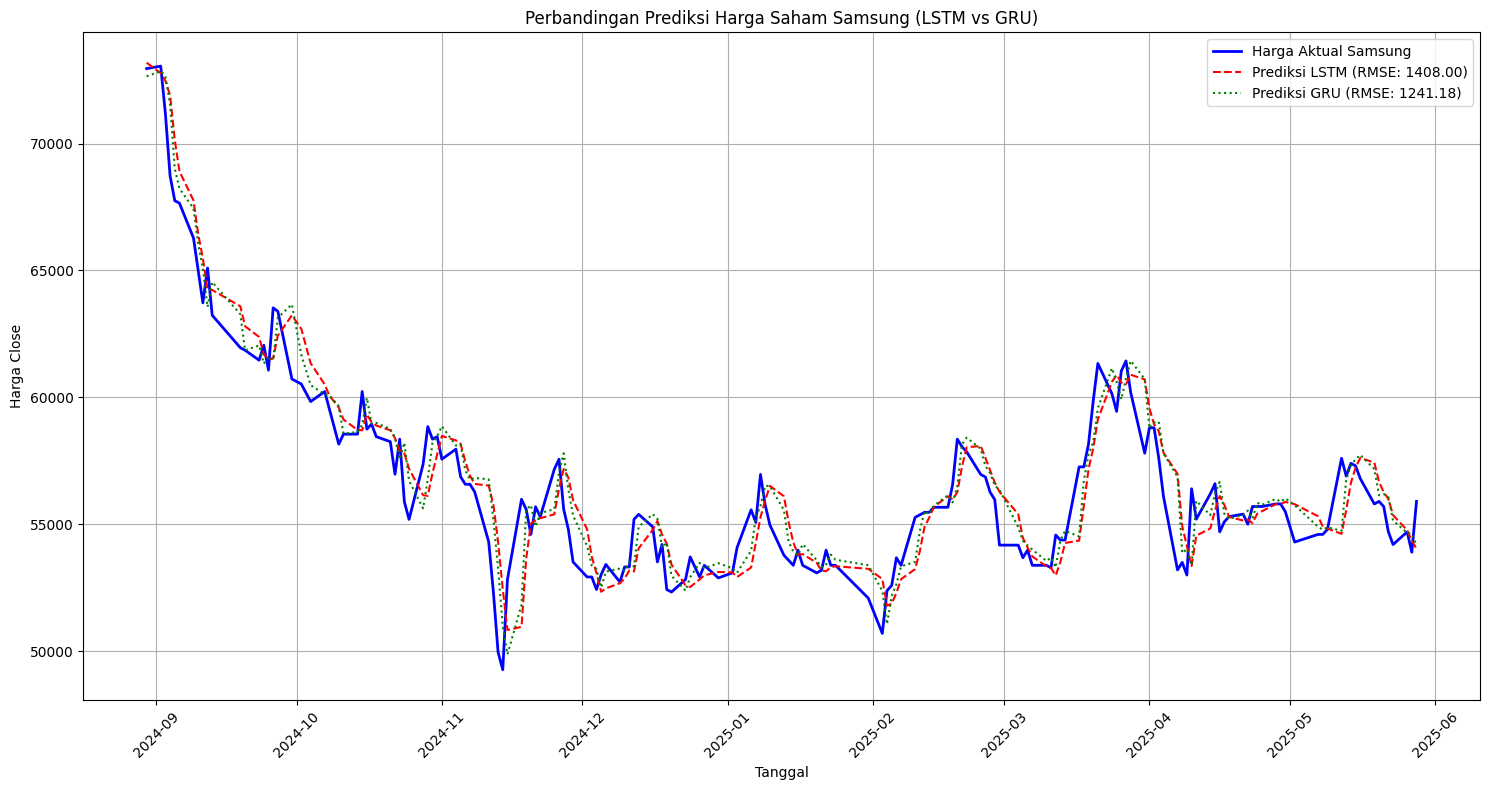

In [18]:
plot_dates = test_data.index[TIME_STEPS : TIME_STEPS + len(y_test_actual)]

plt.figure(figsize=(15, 8))
plt.plot(plot_dates, y_test_actual, color='blue', label='Harga Aktual Samsung', linewidth=2)

if 'LSTM' in model_results:
    plt.plot(plot_dates, model_results['LSTM']['Predictions'], color='red', linestyle='--',
             label=f"Prediksi LSTM (RMSE: {model_results['LSTM']['RMSE']:.2f})")
if 'GRU' in model_results:
    plt.plot(plot_dates, model_results['GRU']['Predictions'], color='green', linestyle=':',
             label=f"Prediksi GRU (RMSE: {model_results['GRU']['RMSE']:.2f})")

plt.title('Perbandingan Prediksi Harga Saham Samsung (LSTM vs GRU)')
plt.xlabel('Tanggal')
plt.ylabel(f'Harga {target_column}')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

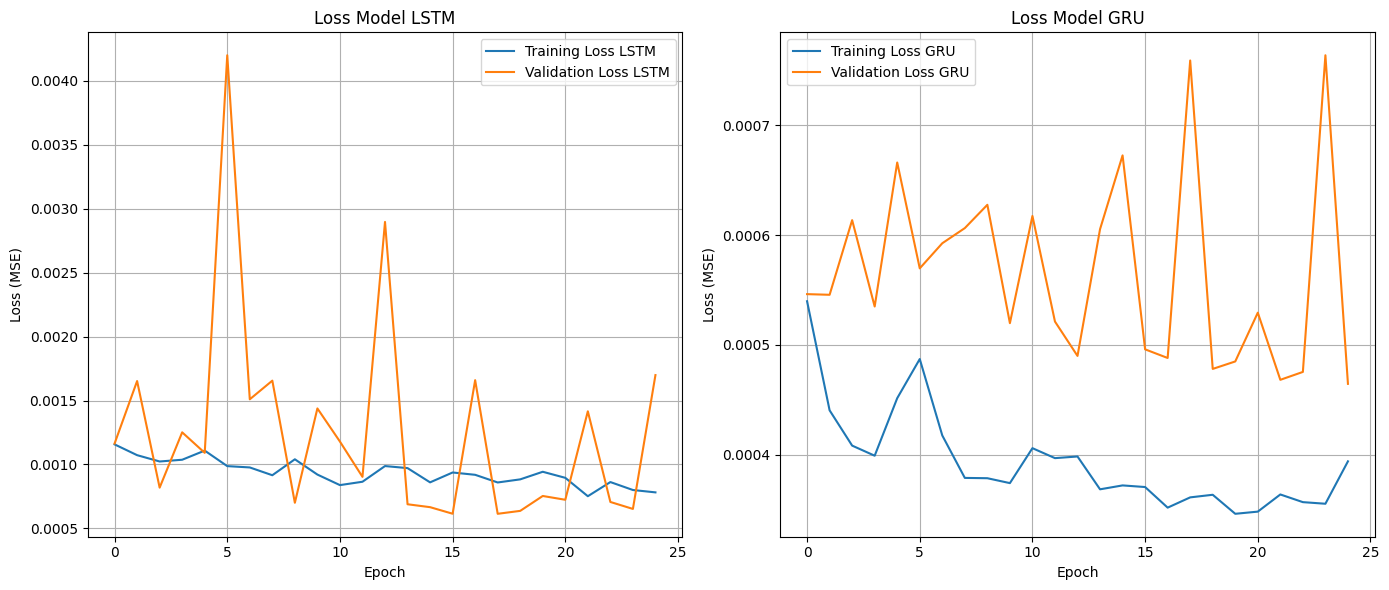

In [19]:
num_models_to_plot = len(model_results)
if num_models_to_plot > 0:
    plt.figure(figsize=(7 * num_models_to_plot, 6))

    plot_idx_counter = 1
    if 'LSTM' in model_results:
        plt.subplot(1, num_models_to_plot, plot_idx_counter)
        plt.plot(model_results['LSTM']['History'].history['loss'], label='Training Loss LSTM')
        plt.plot(model_results['LSTM']['History'].history['val_loss'], label='Validation Loss LSTM')
        plt.title('Loss Model LSTM')
        plt.xlabel('Epoch')
        plt.ylabel('Loss (MSE)')
        plt.legend()
        plt.grid(True)
        plot_idx_counter += 1

    if 'GRU' in model_results:
        plt.subplot(1, num_models_to_plot, plot_idx_counter)
        plt.plot(model_results['GRU']['History'].history['loss'], label='Training Loss GRU')
        plt.plot(model_results['GRU']['History'].history['val_loss'], label='Validation Loss GRU')
        plt.title('Loss Model GRU')
        plt.xlabel('Epoch')
        plt.ylabel('Loss (MSE)')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()
else:
    print("Tidak ada hasil model untuk membuat plot kurva loss.")